In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora, models
import pyLDAvis.gensim_models
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

In [13]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Open Multilingual WordNet（用于词形还原）


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
file_path = 'Topic Modeling Articles_0601.xlsx'
df = pd.read_excel(file_path, sheet_name='Topic Modeling Articles')
df['text'] = df['Title'] + ' ' + df['Abstract Note'].fillna('')


In [14]:
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    
    try:
        # Lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        # Remove short words
        tokens = [word for word in tokens if len(word) > 3]
        return tokens
    except Exception as e:
        print(f"Error processing text: {e}")
        return []

# Apply preprocessing
df['text'] = df['text'].fillna('')

df['processed_text'] = df['text'].apply(preprocess_text)

In [17]:
# Step 5: Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

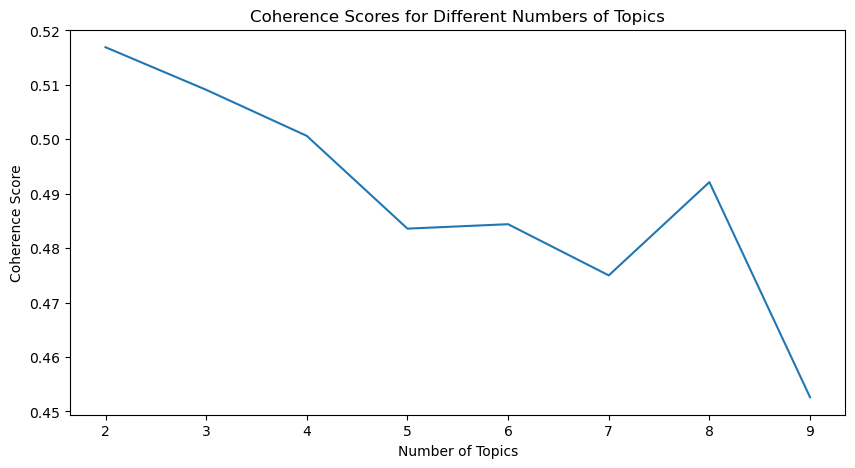

In [18]:
# Step 6: Determine optimal number of topics (coherence score)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, 
                               id2word=dictionary, 
                               num_topics=num_topics,
                               random_state=42)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, 
                                             texts=texts, 
                                             dictionary=dictionary, 
                                             coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# This may take some time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                      corpus=corpus, 
                                                      texts=df['processed_text'], 
                                                      start=2, 
                                                      limit=10, 
                                                      step=1)

# Plot coherence scores
plt.figure(figsize=(10,5))
plt.plot(range(2, 10), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics")
plt.show()

In [24]:
# Step 7: Run LDA with optimal number of topics (based on coherence plot)
optimal_num_topics = 8  # +2 because we started at 2
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_num_topics,
    random_state=42,
    passes=20,              # 增加迭代次数
    alpha='auto',           # 自动学习主题分布
    eta='auto',             # 自动学习词分布
    iterations=400,         # 增加内部迭代
    eval_every=5            # 定期评估模型
)
print("Identified Topics:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}:")
    print(topic)
    print()

Identified Topics:
Topic 0:
0.030*"career" + 0.024*"school" + 0.022*"student" + 0.013*"child" + 0.012*"development" + 0.011*"gender" + 0.009*"study" + 0.008*"primary" + 0.008*"childrens" + 0.008*"elementary"

Topic 1:
0.019*"work" + 0.015*"engineering" + 0.011*"program" + 0.009*"eacute" + 0.008*"career" + 0.008*"experience" + 0.008*"child" + 0.007*"understanding" + 0.006*"childrens" + 0.006*"egravere"

Topic 2:
0.042*"career" + 0.022*"stem" + 0.016*"gender" + 0.014*"student" + 0.012*"child" + 0.012*"study" + 0.009*"girl" + 0.009*"school" + 0.009*"interest" + 0.007*"family"

Topic 3:
0.035*"career" + 0.018*"child" + 0.014*"childrens" + 0.012*"student" + 0.012*"study" + 0.012*"science" + 0.011*"aspiration" + 0.010*"interest" + 0.009*"knowledge" + 0.008*"parent"

Topic 4:
0.047*"career" + 0.014*"child" + 0.012*"development" + 0.012*"study" + 0.009*"student" + 0.009*"research" + 0.008*"school" + 0.008*"influence" + 0.006*"parent" + 0.006*"learning"

Topic 5:
0.020*"career" + 0.019*"student

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.071013 -0.002511       1        1  25.380644
2      0.066714  0.002406       2        1  22.353835
0      0.077512 -0.046246       3        1  20.270338
4     -0.019040 -0.089001       4        1  11.736712
5      0.012892  0.136064       5        1   6.843451
1     -0.203397 -0.008436       6        1   5.588873
6      0.022476 -0.026546       7        1   4.341782
7     -0.028170  0.034269       8        1   3.484366, topic_info=            Term        Freq       Total Category  logprob  loglift
8         career  406.000000  406.000000  Default  30.0000  30.0000
21   development   93.000000   93.000000  Default  29.0000  29.0000
98       science   73.000000   73.000000  Default  28.0000  28.0000
106      student  172.000000  172.000000  Default  27.0000  27.0000
45        school  137.000000  137.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
164     research    1.766390   82.282909   Topic8  -5.4563  -0.4843
76        gender    1.766355   88.815670   Topic8  -5.4563  -0.5608
98       science    1.766236   73.890866   Topic8  -5.4564  -0.3769
105         stem    1.766236   83.934760   Topic8  -5.4564  -0.5043
322    awareness    1.766236   21.448552   Topic8  -5.4564   0.8601

[590 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
386       7  0.726153  abilitiespotential
0         1  0.279952            abstract
0         2  0.223961            abstract
0         3  0.261288            abstract
0         4  0.111981            abstract
...     ...       ...                 ...
115       3  0.167619               young
115       4  0.067048               young
115       5  0.167619               young
115       6  0.067048               young
115       8  0.033524               young

[1080 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 6, 2, 7, 8])

In [26]:
def get_dominant_topic(lda_model, corpus):
    topic_dist = []
    for doc in corpus:
        topic_dist.append(lda_model.get_document_topics(doc))
    dominant_topics = [max(topics, key=lambda x: x[1])[0] for topics in topic_dist]
    return dominant_topics

df['dominant_topic'] = get_dominant_topic(lda_model, corpus)

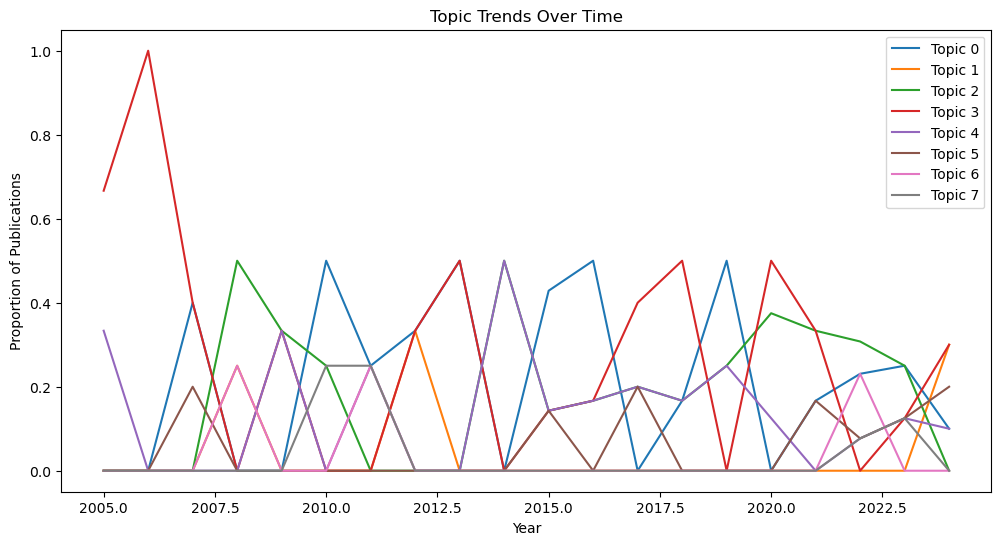

In [29]:
# Step 10: Analyze topics over time
# First ensure Publication Year is clean
df['Publication Year'] = pd.to_numeric(df['Publication Year'], errors='coerce')
df = df.dropna(subset=['Publication Year'])

# Create topic distribution by year
topic_by_year = df.groupby(['Publication Year', 'dominant_topic']).size().unstack().fillna(0)

# Normalize by year totals
topic_by_year = topic_by_year.div(topic_by_year.sum(axis=1), axis=0)

# Plot topic trends over time
plt.figure(figsize=(12, 6))
for topic in topic_by_year.columns:
    plt.plot(topic_by_year.index, topic_by_year[topic], label=f'Topic {topic}')
plt.xlabel('Year')
plt.ylabel('Proportion of Publications')
plt.title('Topic Trends Over Time')
plt.legend()
plt.show()

In [32]:
# Step 11: Identify increasing/decreasing trends
# Calculate trend slopes
from scipy.stats import linregress

trends = {}
for topic in topic_by_year.columns:
    slope, _, _, _, _ = linregress(topic_by_year.index, topic_by_year[topic])
    trends[topic] = slope

# Classify trends
print("\nTopic Trends:")
for topic, slope in sorted(trends.items(), key=lambda x: x[1], reverse=True):
    trend = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stable"
    print(f"Topic {topic}: {trend} trend (slope = {slope:.4f})")

# Step 12: Answer research questions
# Q1: What specific topics have emerged?
print("\nResearch Question 1: Identified Topics and Key Terms")
for idx, topic in lda_model.print_topics(-1):
    terms = [term.split('*')[1].strip('"') for term in topic.split(' + ')]
    print(f"\nTopic {idx} Key Terms:")
    print(", ".join(terms[:10]))  # Show top 10 terms per topic

# Q2: How do topics change over time?
print("\nResearch Question 2: Topic Trends Over Time")
for topic, slope in sorted(trends.items(), key=lambda x: abs(x[1]), reverse=True)[:3]:
    direction = "increased" if slope > 0 else "decreased"
    print(f"Topic {topic} has {direction} in prominence over time")

# Q3: Increasing/decreasing and stable topics
print("\nResearch Question 3: Topic Trend Classification")
increasing = [t for t, s in trends.items() if s > 0.001]
decreasing = [t for t, s in trends.items() if s < -0.001]
stable = [t for t, s in trends.items() if -0.001 <= s <= 0.001]

print("\nIncreasing topics:", increasing)
print("Decreasing topics:", decreasing)
print("Stable topics:", stable)


Topic Trends:
Topic 2: increasing trend (slope = 0.0071)
Topic 5: increasing trend (slope = 0.0056)
Topic 0: increasing trend (slope = 0.0030)
Topic 1: increasing trend (slope = 0.0006)
Topic 4: decreasing trend (slope = -0.0005)
Topic 7: decreasing trend (slope = -0.0005)
Topic 6: decreasing trend (slope = -0.0012)
Topic 3: decreasing trend (slope = -0.0141)

Research Question 1: Identified Topics and Key Terms

Topic 0 Key Terms:
career, school, student, child, development, gender, study, primary, childrens, elementary

Topic 1 Key Terms:
work, engineering, program, eacute, career, experience, child, understanding, childrens, egravere

Topic 2 Key Terms:
career, stem, gender, student, child, study, girl, school, interest, family

Topic 3 Key Terms:
career, child, childrens, student, study, science, aspiration, interest, knowledge, parent

Topic 4 Key Terms:
career, child, development, study, student, research, school, influence, parent, learning

Topic 5 Key Terms:
career, student, 